In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [74]:
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [75]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
# Check if the data is already normalized
pixel_min = data.iloc[:, 1:].min().min() # Select all rows, and all columns except the first column
pixel_max = data.iloc[:, 1:].max().max()
print(f'Max: {pixel_max}')
print(f'min: {pixel_min}')

# +======== OUTPUT ========+
# Max: 255
# min: 0

# Then we can see that the data isn't normalized yet

Max: 255
min: 0


In [77]:
data = np.array(data)
# data = data / 255.0
m, n = data.shape
np.random.shuffle(data)

print(f'data.shape (m, n): {data.shape}')
print(f'm, n: {m}, {n}')

# +=========== Output ===========+
# data.shape (m, n): (42000, 785)
# m, n: 42000, 785

# We can see that there are 42000 rows and 785 columns

data.shape (m, n): (42000, 785)
m, n: 42000, 785


In [78]:
# Only take the first 1000 data, and then transpose it
# The shape will be from (1000, 785) to (785, 1000)
data_dev = data[0:1000].T
print(f'data_dev.shape after T: {data_dev.shape}')

# Notice that the shape is (m, n) = (42000, 785)
# The n is 785 since it holds 784 pixels + 1 label
# The label is located on the first row
Y_dev = data_dev[0, :] # The label is on the 1st row
X_dev = data_dev[1:n, :] # Take the remaining data (from 1:n)
X_dev = X_dev / 255.0

print(f'Y_dev.shape: {Y_dev.shape}')
print(f'X_dev.shape: {X_dev.shape}')

data_dev.shape after T: (785, 1000)
Y_dev.shape: (1000,)
X_dev.shape: (784, 1000)


In [79]:
# Take the remaining data, from 1000:m, and then transpose it
# The shape will be from (42000-1000, 785) to (785, 42000-1000)
data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.0

print(f'Y_train.shape: {Y_train.shape}')
print(f'X_train.shape: {X_train.shape}')

Y_train.shape: (41000,)
X_train.shape: (784, 41000)


In [80]:
def init_params():
    """
    Function to initialize the parameters with random values from [-0.5, 0.5]
    - W: Weights
    - b: Bias
    - 1: Hidden layer
    - 2. Output layer
    """
    # Initialize with the weights ranging from [-0.5, 0.5]
    W1 = np.random.rand(20, 784) - 0.5
    b1 = np.random.rand(20, 1) - 0.5
    W2 = np.random.rand(10, 20) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    
    return W1, b1, W2, b2

def ReLU(Z):
    """
    Function to calculate the ReLU of a linear combination of weights and biases
    """
    return np.maximum(0, Z)

def softmax(Z):
    """
    Function to calculate the Softmax of a linear combination of weights and biases
    """
    return np.exp(Z) / np.sum(np.exp(Z))

def softmax_custom(Z):
    Z_exp = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    
    return Z_exp / np.sum(Z_exp, axis=0, keepdims=True)

def one_hot(Y):
    """
    Function to one-hot-encode the label
    """
    one_hot_Y = np.zeros((Y.size, 10))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    
    return one_hot_Y

def deriv_ReLU(Z):
    """
    Function to calculate the derivative of ReLU activation function
    """
    return Z > 0

def forward_prop(W1, b1, W2, b2, X):
    """
    Z === pre_h: Calculation of weights + bias
    A: ActvFn(Z)
    """
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
#     A2 = softmax(Z2)
    A2 = softmax_custom(Z2)
    
    return Z1, A1, Z2, A2
    
def backward_prop(Z1, A1, Z2, A2, W2, X, Y):
    m = Y.size
    
    one_hot_Y = one_hot(Y)
    
    dZ2 = A2 - one_hot_Y
    dW2 = 1/m * dZ2.dot(A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
    
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)
    dW1 = 1/m * dZ1.dot(X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
    
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    return W1, b1, W2, b2

def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
#     print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

In [81]:
import time
from datetime import timedelta

def gradient_descent(X, Y, epochs, learning_rate):
    # Initialize paramaters
    W1, b1, W2, b2 = init_params()
    
    acuracy_dict = dict()
    
    start_time = time.time()
    for epoch in range(epochs):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
        
        if epoch % 10 == 0:
            print(f'Epoch: {epoch}')
            print(f'Accuracy: {get_accuracy(get_predictions(A2), Y)}')
            print(f'Time: {timedelta(seconds=time.time() - start_time)}')
            
            accuracy_dict[epoch] = get_accuracy(get_predictions(A2), Y)
            
    return W1, b1, W2, b2, accuracy_dict

In [82]:
import time
from datetime import timedelta

start_time = time.time()
W1, b1, W2, b2, accuracy_dict = gradient_descent(X_train, Y_train, 500, 0.1)
print(f'Time elapsed: {timedelta(seconds=time.time() - start_time)}')

Epoch: 0
Accuracy: 0.10453658536585365
Time: 0:00:00.141014
Epoch: 10
Accuracy: 0.23460975609756096
Time: 0:00:01.501758
Epoch: 20
Accuracy: 0.3961707317073171
Time: 0:00:02.867976
Epoch: 30
Accuracy: 0.49634146341463414
Time: 0:00:04.238369
Epoch: 40
Accuracy: 0.5616585365853659
Time: 0:00:05.590671
Epoch: 50
Accuracy: 0.6080731707317073
Time: 0:00:06.951980
Epoch: 60
Accuracy: 0.6429024390243903
Time: 0:00:08.319114
Epoch: 70
Accuracy: 0.6712439024390244
Time: 0:00:09.774852
Epoch: 80
Accuracy: 0.6944634146341463
Time: 0:00:11.127172
Epoch: 90
Accuracy: 0.7132682926829268
Time: 0:00:12.495737
Epoch: 100
Accuracy: 0.728609756097561
Time: 0:00:13.866198
Epoch: 110
Accuracy: 0.7425609756097561
Time: 0:00:15.239794
Epoch: 120
Accuracy: 0.755219512195122
Time: 0:00:16.594154
Epoch: 130
Accuracy: 0.7661951219512195
Time: 0:00:17.949481
Epoch: 140
Accuracy: 0.7764146341463415
Time: 0:00:19.434817
Epoch: 150
Accuracy: 0.7842682926829269
Time: 0:00:20.803225
Epoch: 160
Accuracy: 0.79275609756

In [83]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(current_image, W1, b1, W2, b2)
    label = Y_train[index]
    
    print(f'Prediction: {prediction}')
    print(f'Label: {label}')
    
    current_image = current_image.reshape((28, 28)) * 255
    
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

In [92]:
import random

print(random.randint(0, 100))
print(len(data))

34
42000


Prediction: [5]
Label: 5


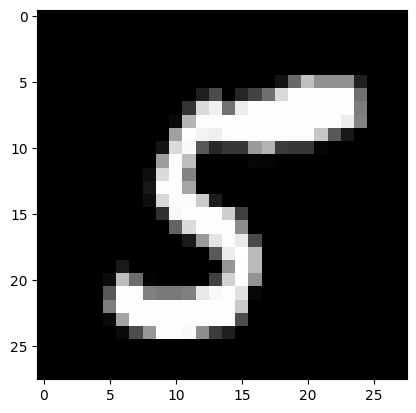

Prediction: [8]
Label: 8


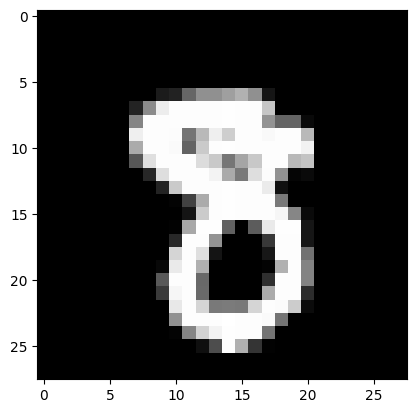

Prediction: [4]
Label: 4


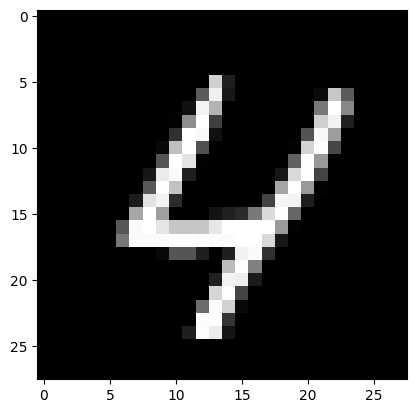

Prediction: [7]
Label: 7


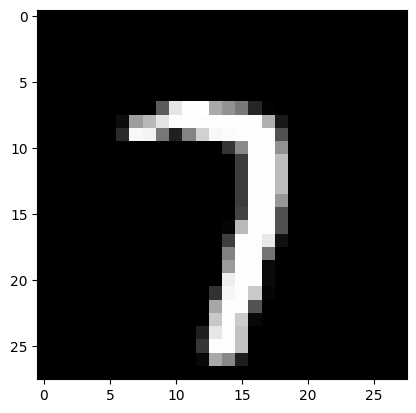

Prediction: [8]
Label: 8


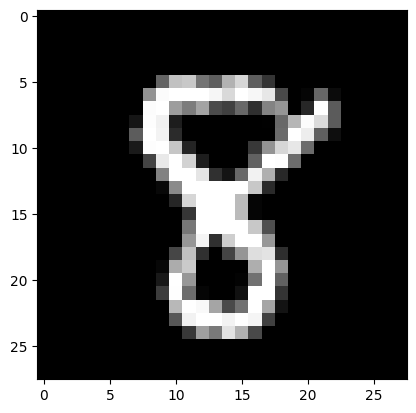

Prediction: [3]
Label: 3


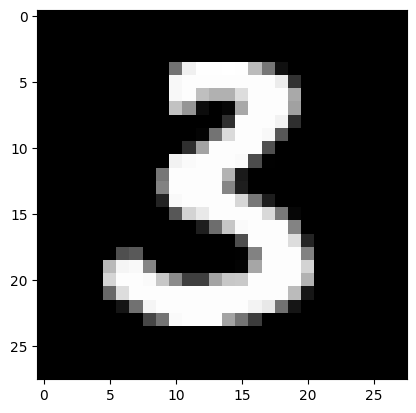

Prediction: [7]
Label: 7


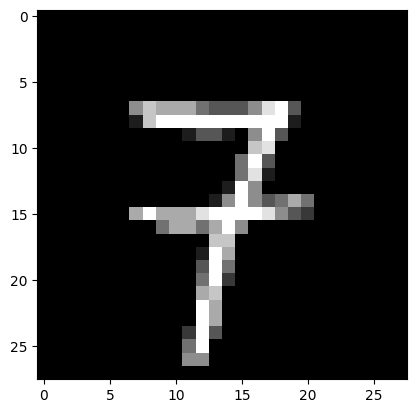

Prediction: [4]
Label: 4


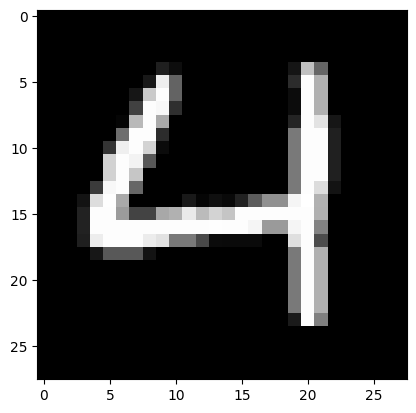

Prediction: [3]
Label: 9


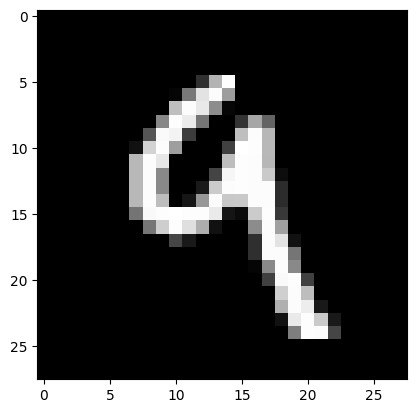

Prediction: [7]
Label: 7


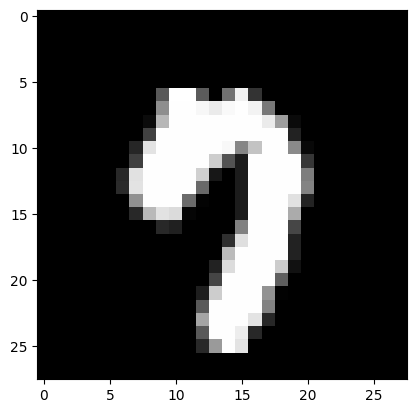

In [93]:
import random

for i in range(10):
    idx = random.randint(0, len(data))
    test_prediction(idx, W1, b1, W2, b2)

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490]


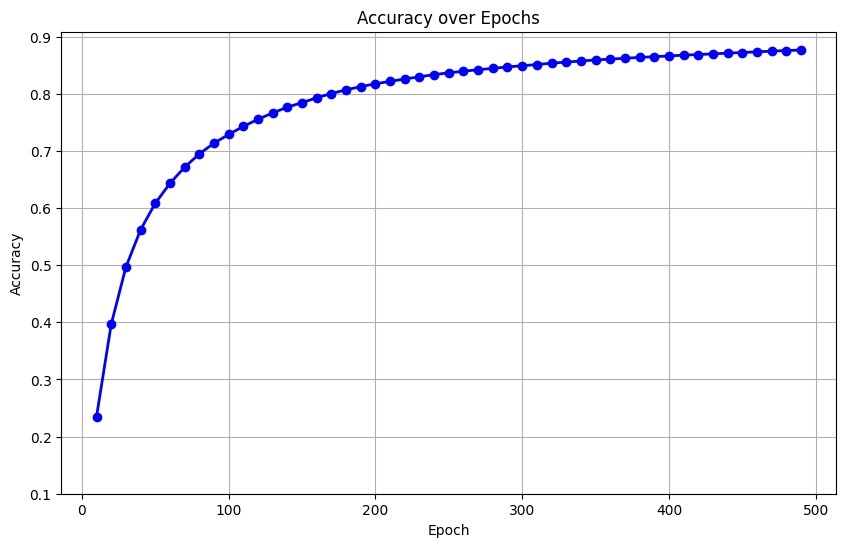

In [90]:
epochs = list(accuracy_dict.keys())
print(epochs)
accuracies = list(accuracy_dict.values())
# accuracies = list(float(f'{(accuracy_dict.values()):.3f}'))

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)

plt.yticks([0.1 * i for i in range(1, 10)])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.grid(True)
plt.show()